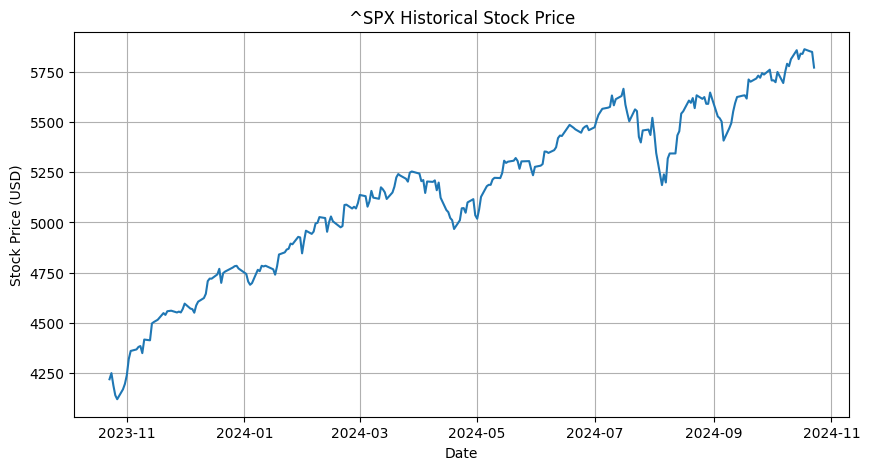

In [69]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
from sklearn.metrics import r2_score



def fetch_options_data(ticker_symbol, expiration_date):
    ticker = yf.Ticker(ticker_symbol)
    options_dates = ticker.options
    # We'll use the nearest expiry date for our analysis
    options_data = ticker.option_chain(options_dates[expiration_date])
    return options_data.calls, options_data.puts

def fetch_historical_stock_data(ticker_symbol, period="1y"):
    ticker = yf.Ticker(ticker_symbol)
    stock_data = ticker.history(period=period)
    
    if stock_data.empty:
        raise ValueError(f"No historical stock data found for ticker '{ticker_symbol}'.")
    return stock_data

ticker_symbol = "^SPX"

stock_data = fetch_historical_stock_data(ticker_symbol, period="1y")

plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'])
plt.title(f'{ticker_symbol} Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)


In [70]:
# Fetch available expiration dates
ticker = yf.Ticker(ticker_symbol)
expiration_dates = ticker.options

# Print all available expiration dates
print("Available Expiration Dates for SPX:")
for date in expiration_dates:
    print(date)


EXPIRATION_DATE_INDEX = 20
expiration_in_one_month = expiration_dates[EXPIRATION_DATE_INDEX]  # Adjust the index as necessary

# Print the selected expiration date
print(f"\nFetching options for expiration date: {expiration_in_one_month}")

Available Expiration Dates for SPX:
2024-10-23
2024-10-24
2024-10-25
2024-10-28
2024-10-29
2024-10-30
2024-10-31
2024-11-01
2024-11-04
2024-11-05
2024-11-06
2024-11-07
2024-11-08
2024-11-11
2024-11-12
2024-11-13
2024-11-14
2024-11-15
2024-11-18
2024-11-19
2024-11-20
2024-11-21
2024-11-22
2024-11-25
2024-11-26
2024-11-29
2024-12-06
2024-12-20
2024-12-31
2025-01-17
2025-01-31
2025-02-21
2025-02-28
2025-03-21
2025-03-31
2025-04-17
2025-05-16
2025-06-20
2025-06-30
2025-07-18
2025-08-15
2025-09-19
2025-09-30
2025-10-17
2025-11-21
2025-12-19
2026-01-16
2026-03-20
2026-06-18
2026-12-18
2027-12-17
2028-12-15
2029-12-21

Fetching options for expiration date: 2024-11-20


5772.9599609375


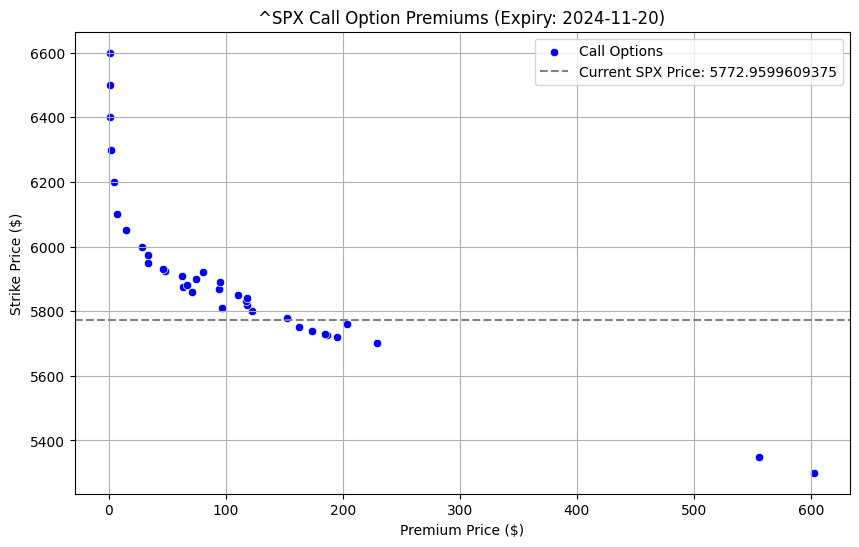

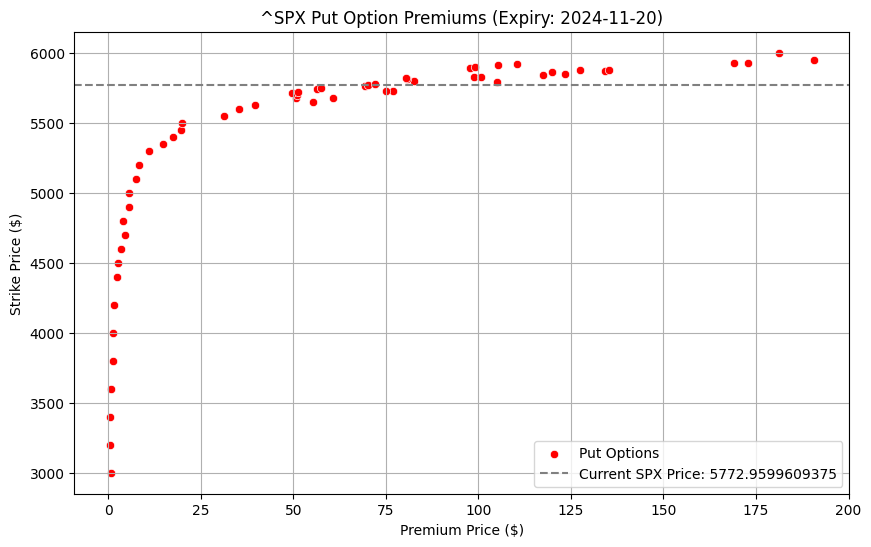

Plotting option premiums for expiration date: 2024-11-20
Current SPX Price: 5772.9599609375
Note: The 'lastPrice' represents the most recent trade, which may not always be from today. Check 'volume' for recent trading activity.



In [71]:
def fetch_current_stock_price(ticker_symbol):
    """
    Fetches the current stock price for the given ticker symbol.
    
    Parameters:
    - ticker_symbol (str): The ticker symbol (e.g., 'SPX')
    
    Returns:
    - current_price (float): The latest stock price
    """
    ticker = yf.Ticker(ticker_symbol)
    stock_data = ticker.history(period="1d")
    current_price = stock_data['Close'].iloc[-1]  # Get the most recent closing price
    return current_price

spx_calls, spx_puts = fetch_options_data(ticker_symbol, EXPIRATION_DATE_INDEX)

#print(spx_calls)

# Fetch the current stock price
current_stock_price = fetch_current_stock_price(ticker_symbol)
print(current_stock_price)

# Plot Call Option Premiums for SPX with a horizontal line for the current stock price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spx_calls, x='lastPrice', y='strike', color='blue', label='Call Options')
plt.axhline(y=current_stock_price, color='gray', linestyle='--', label=f'Current SPX Price: {current_stock_price}')
plt.title(f'{ticker_symbol} Call Option Premiums (Expiry: {expiration_in_one_month})')
plt.xlabel('Premium Price ($)')
plt.ylabel('Strike Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Put Option Premiums for SPX with a horizontal line for the current stock price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spx_puts, x='lastPrice', y='strike', color='red', label='Put Options')
plt.axhline(y=current_stock_price, color='gray', linestyle='--', label=f'Current SPX Price: {current_stock_price}')
plt.title(f'{ticker_symbol} Put Option Premiums (Expiry: {expiration_in_one_month})')
plt.xlabel('Premium Price ($)')
plt.ylabel('Strike Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print the expiration date for clarity
print(f"Plotting option premiums for expiration date: {expiration_in_one_month}")
print(f"Current SPX Price: {current_stock_price}")
print("Note: The 'lastPrice' represents the most recent trade, which may not always be from today. Check 'volume' for recent trading activity.\n")

In [72]:
def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

volatility = calculate_historical_volatility(stock_data)
print(f"{ticker_symbol} Historical Volatility: {jpm_volatility}")

# Fetch data for the 13-week T-bill (^IRX is the ticker for the 13-week Treasury Bill index on Yahoo Finance)
t_bill = yf.Ticker("^IRX")
t_bill_data = t_bill.history(period="1d")

# The yield is typically expressed as an annual percentage, so divide by 100
risk_free_rate = t_bill_data['Close'].iloc[-1] / 100
print(f"Estimated risk-free rate (3-month T-Bill): {risk_free_rate}")

^SPX Historical Volatility: 0.19909059366562598
Estimated risk-free rate (3-month T-Bill): 0.04502999782562256


In [73]:

class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T        # Time to expiration in years
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))







Number of strike prices call:  36
Number of premium call options:  36
Number of strike prices put:  57
Number of strike prices put:  57
Current stock price: 5772.9599609375


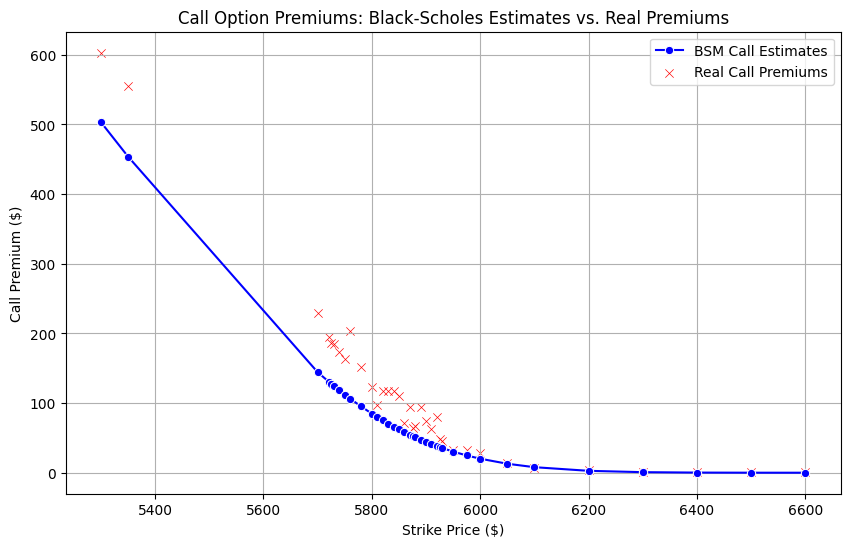

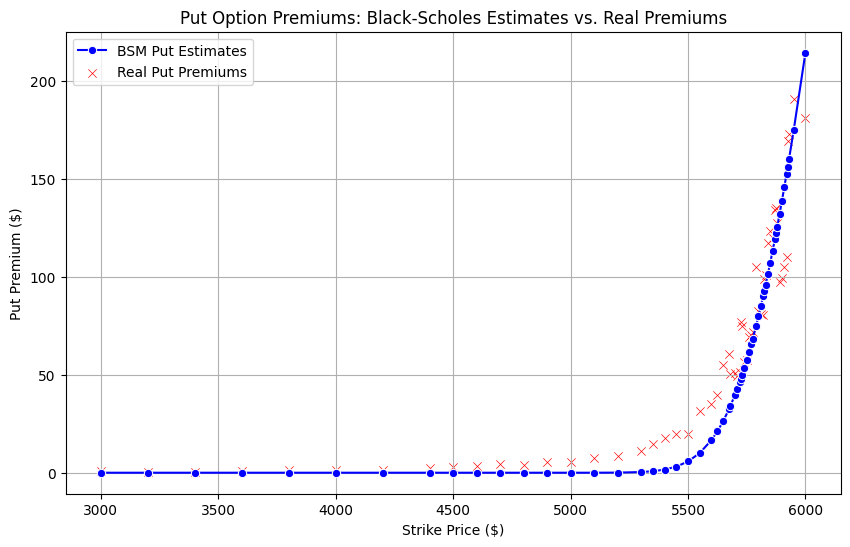

In [74]:
strike_prices_call = spx_calls['strike'].values
strike_prices_put =  spx_puts['strike'].values

real_call_premiums = spx_calls['lastPrice'].values
real_put_premiums = spx_puts['lastPrice'].values

print("Number of strike prices call: ", len(strike_prices_call))
print("Number of premium call options: ", len(real_call_premiums))

print("Number of strike prices put: ",len(strike_prices_put))
print("Number of strike prices put: ",len(real_put_premiums))

bsm_call_premiums = []
bsm_put_premiums = []

print(f"Current stock price: {current_stock_price}")
# Loop through each strike price and calculate the call and put option premiums
for K in strike_prices_call:
    bsm = BlackScholesModel(S=current_stock_price, K=K, T=1/12, r=risk_free_rate, sigma=volatility)
    bsm_call_premiums.append(bsm.call_option_price())

for K in strike_prices_put:
    bsm = BlackScholesModel(S=current_stock_price, K=K, T=1/12, r=risk_free_rate, sigma=volatility)
    bsm_put_premiums.append(bsm.put_option_price())


# Plot Call Option Premiums: Black-Scholes estimates vs. real premiums
plt.figure(figsize=(10, 6))
sns.lineplot(x=strike_prices_call, y=call_premiums, label='BSM Call Estimates', color='blue', marker='o')
sns.scatterplot(x=strike_prices_call, y=real_call_premiums, label='Real Call Premiums', color='red', marker='x')
plt.title('Call Option Premiums: Black-Scholes Estimates vs. Real Premiums')
plt.xlabel('Strike Price ($)')
plt.ylabel('Call Premium ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Put Option Premiums: Black-Scholes estimates vs. real premiums
plt.figure(figsize=(10, 6))
sns.lineplot(x=strike_prices_put, y=put_premiums, label='BSM Put Estimates', color='blue', marker='o')
sns.scatterplot(x=strike_prices_put, y=real_put_premiums, label='Real Put Premiums', color='red', marker='x')
plt.title('Put Option Premiums: Black-Scholes Estimates vs. Real Premiums')
plt.xlabel('Strike Price ($)')
plt.ylabel('Put Premium ($)')
plt.legend()
plt.grid(True)
plt.show()



In [75]:
# Call option premiums
r2_call = r2_score(real_call_premiums, call_premiums_bsm)

# Put option premiums
r2_put = r2_score(real_put_premiums, put_premiums_bsm)

# Print R² scores
print(f"R² Score for Call Options: {r2_call:.4f}")
print(f"R² Score for Put Options: {r2_put:.4f}")

ModuleNotFoundError: No module named 'sklearn'